In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import os
import gc
from model_ensemble_toolbox import stacking

In [2]:
print("--- Loading Data ---")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
datasert_df = pd.read_csv('personality_dataset.csv')#已经用mean填充了数值,mode填充了分类型数据

print("--- Engineering 'match_p' feature using merge ---")

datasert_df_prep = datasert_df.rename(columns={'Personality': 'match_p'}).drop_duplicates(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance','Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency'])
merge_cols = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance','Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']
train_df = train_df.merge(datasert_df_prep, how='left', on=merge_cols)
test_df = test_df.merge(datasert_df_prep, how='left', on=merge_cols)

--- Loading Data ---
--- Engineering 'match_p' feature using merge ---


In [3]:
print("--- Performing Imputation and Initial Feature Prep ---")
train_id = train_df['id']; test_id = test_df['id']
y_train_series = train_df['Personality']
all_data = pd.concat([train_df.drop(['id', 'Personality'], axis=1), test_df.drop('id', axis=1)], ignore_index=True)

--- Performing Imputation and Initial Feature Prep ---


In [4]:
def fill_missing_by_quantile_group(df, group_source_col, target_col):
    """
    按分位数分组，使用组内中位数填充目标列的缺失值。

    该函数实现了一种智能的缺失值填充方法。它首先根据 `group_source_col` 列的
    数值分布(分位数),将数据分成四组(0-25%, 25-50%, 50-75%, 75-100%).然后，
    计算每个组内 `target_col` 列的中位数。最后，使用各行对应分组的中位数来填充
    `target_col` 中的缺失值(NaN)。

    这种方法比使用全局中位数填充更精细，特别适用于源列和目标列之间存在相关性的场景
    （例如，使用年龄分组来填充收入的缺失值）。

    参数:
        df (pd.DataFrame): 待处理的Pandas DataFrame。
        group_source_col (str): 用于分箱和分组的源列名。此列应该是数值类型，以便计算分位数。
        target_col (str): 包含缺失值(NaN)并需要被填充的目标列名。

    返回值:
        pd.DataFrame: 填充了缺失值后的DataFrame。
    """
        
    temp_bin_col = f'{group_source_col}_bin'
    df[temp_bin_col] = pd.qcut(df[group_source_col], 
                        q=[0, 0.25, 0.5, 0.75, 1.0], 
                        labels=[1,2,3,4], 
                        duplicates='drop')
    df[target_col] = df[target_col].fillna(df.groupby(temp_bin_col)[target_col].transform('median'))
    df.drop(columns=[temp_bin_col], inplace=True)
    return df

In [5]:
#认为Social_event_attendance和Time_spend_Alone有关，用前者分箱为后者取中位数缺失值
#认为Going_outside和Time_spend_Alone有关，用前者分箱为后者取中位数填充缺失值
#再用全部的中位数fillna还没有被补全的Time_spend_alone
all_data = fill_missing_by_quantile_group(all_data, 'Social_event_attendance', 'Time_spent_Alone')
all_data = fill_missing_by_quantile_group(all_data, 'Going_outside', 'Time_spent_Alone')
all_data['Time_spent_Alone'].fillna(all_data['Time_spent_Alone'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Going_outside', 'Social_event_attendance')
all_data = fill_missing_by_quantile_group(all_data, 'Friends_circle_size', 'Social_event_attendance')
all_data['Social_event_attendance'].fillna(all_data['Social_event_attendance'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Social_event_attendance', 'Going_outside')
all_data['Going_outside'].fillna(all_data['Going_outside'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Post_frequency', 'Friends_circle_size')
all_data = fill_missing_by_quantile_group(all_data, 'Going_outside', 'Friends_circle_size')
all_data['Friends_circle_size'].fillna(all_data['Friends_circle_size'].median(), inplace=True)

all_data = fill_missing_by_quantile_group(all_data, 'Friends_circle_size', 'Post_frequency')
all_data['Post_frequency'].fillna(all_data['Post_frequency'].median(), inplace=True)

In [6]:
numerical_features = all_data.select_dtypes(include=np.number).columns.tolist()

In [7]:
print("--- Creating Final Advanced Features ---")
all_data['social_mean'] = all_data[numerical_features].mean(axis=1)
all_data['social_std'] = all_data[numerical_features].std(axis=1)
all_data['social_sum'] = all_data[numerical_features].sum(axis=1)

--- Creating Final Advanced Features ---


In [8]:
# kmeans方法获得聚类特征
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
all_data['cluster'] = kmeans.fit_predict(all_data[numerical_features])

In [9]:
# 获得多项式特征
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False) # interaction_only=False gives x*y AND x^2
# 同时生成多项式特征（如 a^2, b^2）和交互特征（如 a*b）；True只生成交互特征
poly_features = poly.fit_transform(all_data[numerical_features])
poly_df = pd.DataFrame(poly_features, 
                        columns=poly.get_feature_names_out(numerical_features))
poly_df.drop(columns=numerical_features, inplace=True)
all_data = pd.concat([all_data.reset_index(drop=True), poly_df], axis=1)

In [10]:
# 填充分类型缺失值，用Unknown填充
all_data.fillna({'Stage_fear': 'Unknown', 'Drained_after_socializing': 'Unknown', 'match_p': 'Unknown'}, inplace=True)
all_data = pd.get_dummies(all_data, 
                            columns=['Stage_fear', 'Drained_after_socializing', 'match_p', 'cluster'], 
                            prefix=['Stage', 'Drained', 'match', 'cluster'])


X = all_data[:len(train_df)]
X_test = all_data[len(train_df):]

y_encoded = LabelEncoder().fit_transform(y_train_series)

[I 2025-07-15 19:13:04,146] A new study created in memory with name: no-name-4f675118-c5e8-40b6-a91c-107dcff90786
[I 2025-07-15 19:13:57,872] Trial 0 finished with value: 0.9645048812789992 and parameters: {'iterations': 991, 'learning_rate': 0.047840194701658685, 'depth': 11, 'subsample': 0.7881553474069677, 'l2_leaf_reg': 1.2191757130478098}. Best is trial 0 with value: 0.9645048812789992.
[I 2025-07-15 19:15:47,802] Trial 1 finished with value: 0.9647747594881576 and parameters: {'iterations': 1203, 'learning_rate': 0.046479014981920336, 'depth': 12, 'subsample': 0.628119635671736, 'l2_leaf_reg': 3.205784197649453}. Best is trial 1 with value: 0.9647747594881576.
[I 2025-07-15 19:16:02,865] Trial 2 finished with value: 0.9654495779686262 and parameters: {'iterations': 1885, 'learning_rate': 0.08260509529892339, 'depth': 7, 'subsample': 0.7070871766461245, 'l2_leaf_reg': 5.722322728766367}. Best is trial 2 with value: 0.9654495779686262.
[I 2025-07-15 19:16:33,678] Trial 3 finished w


Best Optuna Parameters in CatBoost: {'iterations': 1066, 'learning_rate': 0.010326026960636692, 'depth': 7, 'subsample': 0.794674214543214, 'l2_leaf_reg': 3.1059079609938762}
0:	learn: 0.6762770	total: 4.2ms	remaining: 4.47s
1:	learn: 0.6596693	total: 8.5ms	remaining: 4.52s
2:	learn: 0.6435192	total: 12.6ms	remaining: 4.47s
3:	learn: 0.6280517	total: 17.2ms	remaining: 4.56s
4:	learn: 0.6131614	total: 19.7ms	remaining: 4.17s
5:	learn: 0.5986382	total: 23.9ms	remaining: 4.21s
6:	learn: 0.5846038	total: 26.3ms	remaining: 3.98s
7:	learn: 0.5708745	total: 29.8ms	remaining: 3.94s
8:	learn: 0.5575092	total: 33.5ms	remaining: 3.93s
9:	learn: 0.5446483	total: 37.3ms	remaining: 3.94s
10:	learn: 0.5319856	total: 40.9ms	remaining: 3.92s
11:	learn: 0.5199681	total: 44.7ms	remaining: 3.92s
12:	learn: 0.5083881	total: 48.1ms	remaining: 3.9s
13:	learn: 0.4970767	total: 51.2ms	remaining: 3.85s
14:	learn: 0.4861531	total: 54.3ms	remaining: 3.81s
15:	learn: 0.4756124	total: 57.7ms	remaining: 3.79s
16:	l

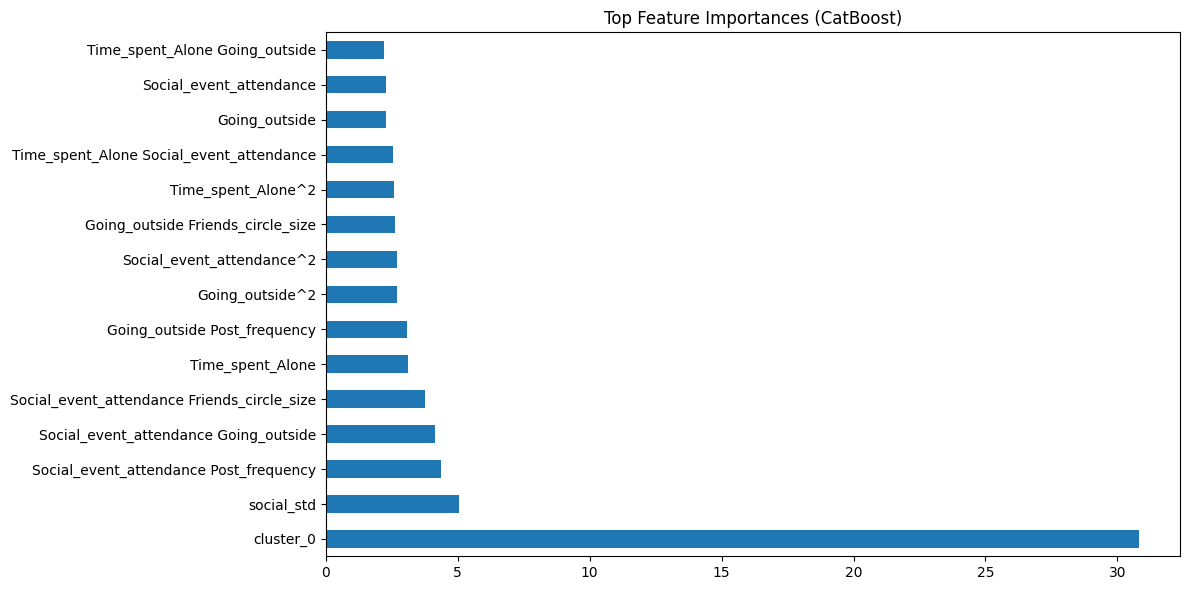

[I 2025-07-15 19:26:11,102] A new study created in memory with name: no-name-6e8845fc-d46c-4996-a7cf-ebfd483c25de
[I 2025-07-15 19:26:21,323] Trial 0 finished with value: 0.9655845622779917 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.14666498387204666, 'subsample': 0.5923826768624478, 'colsample_bytree': 0.7987775036169964}. Best is trial 0 with value: 0.9655845622779917.
[I 2025-07-15 19:26:34,414] Trial 1 finished with value: 0.96841877533211 and parameters: {'n_estimators': 489, 'max_depth': 3, 'learning_rate': 0.138374146409321, 'subsample': 0.5466354520546168, 'colsample_bytree': 0.6773741969936395}. Best is trial 1 with value: 0.96841877533211.
[I 2025-07-15 19:26:42,911] Trial 2 finished with value: 0.9700382996224693 and parameters: {'n_estimators': 394, 'max_depth': 3, 'learning_rate': 0.047810943874235894, 'subsample': 0.7059210617477178, 'colsample_bytree': 0.6415140285595344}. Best is trial 2 with value: 0.9700382996224693.
[I 2025-07-15 19:27:0


Best Optuna Parameters in xgboost: {'n_estimators': 319, 'max_depth': 4, 'learning_rate': 0.013136983310807433, 'subsample': 0.9248588402014203, 'colsample_bytree': 0.5533650597715791}

Tuned XGBoost Validation Accuracy: 0.9741
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2740
           1       0.95      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.97      0.97      0.97      3705
weighted avg       0.97      0.97      0.97      3705



<Figure size 1200x600 with 0 Axes>

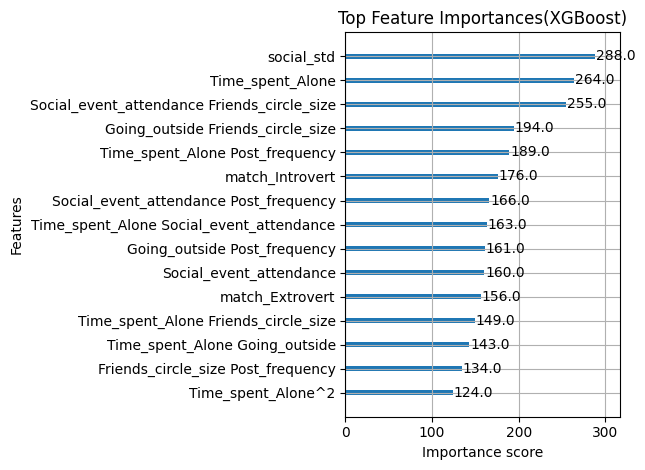

[I 2025-07-15 19:32:19,186] A new study created in memory with name: no-name-f75450b0-9707-46ba-b086-e03ea0bc39f9
[I 2025-07-15 19:34:07,136] Trial 0 finished with value: 0.9626153239563155 and parameters: {'n_estimators': 1963, 'learning_rate': 0.02072181756615848, 'num_leaves': 226, 'subsample': 0.6514792044942791, 'colsample_bytree': 0.7627090478642804}. Best is trial 0 with value: 0.9626153239563155.
[I 2025-07-15 19:35:35,153] Trial 1 finished with value: 0.9630202505656732 and parameters: {'n_estimators': 1449, 'learning_rate': 0.01762371587116473, 'num_leaves': 175, 'subsample': 0.8329747691863242, 'colsample_bytree': 0.6544474346784755}. Best is trial 1 with value: 0.9630202505656732.
[I 2025-07-15 19:36:17,548] Trial 2 finished with value: 0.9620754855662838 and parameters: {'n_estimators': 1235, 'learning_rate': 0.07717475578894747, 'num_leaves': 182, 'subsample': 0.8449757567939342, 'colsample_bytree': 0.6607275643341904}. Best is trial 1 with value: 0.9630202505656732.
[I 2


Best Optuna Parameters in LightGBM: {'n_estimators': 536, 'learning_rate': 0.010423827533362096, 'num_leaves': 50, 'subsample': 0.6951639058191624, 'colsample_bytree': 0.82083592765334}

Tuned LightGBM Validation Accuracy: 0.9746
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2740
           1       0.95      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.97      0.97      0.97      3705
weighted avg       0.97      0.97      0.97      3705



<Figure size 1200x600 with 0 Axes>

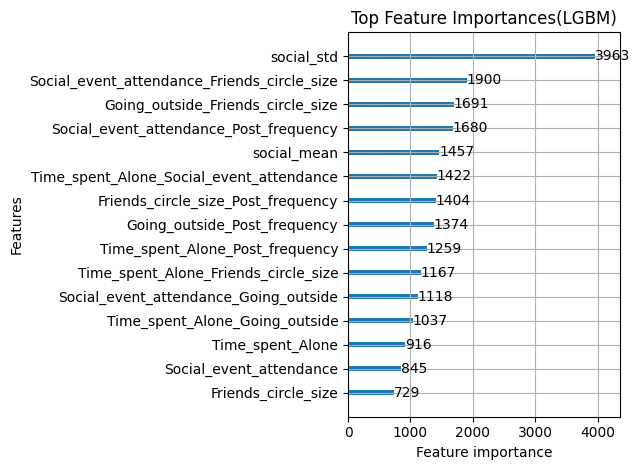

--- FOLD 1/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 2/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 3/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 4/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 5/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 6/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 7/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 8/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 9/10 ---
  Training cat...
  Training xgb...
  Training lgb...
--- FOLD 10/10 ---
  Training cat...
  Training xgb...
  Training lgb...


In [11]:
final_predictions = stacking(X, y_encoded, X_test, n_splits=10)

In [12]:

le_final = LabelEncoder().fit(['Extrovert', 'Introvert']); final_labels = le_final.inverse_transform(final_predictions)
submission_df = pd.DataFrame({'id': test_id, 'Personality': final_labels})
submission_df.to_csv('submission_final_advanced_feats_v2.csv', index=False)
print("\n✅ Final submission file 'submission_final_advanced_feats_v2.csv' created!")


✅ Final submission file 'submission_final_advanced_feats_v2.csv' created!
